# Synthetic Data Generation with GWKokab

Welcome to this Python notebook, where we'll learn how to leverage GWKokab to generate synthetic data. Let's get started and discover how GWKokab can help us generate high-quality synthetic data!

In this tutorial we are generating data from `Wysocki2019MassModel`, see eq (7) of [Wysocki et al](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.100.043012), for the primary and secondary mass of the binary system, and Truncated Normal distribution for the eccentricity of the orbit. The models are defined as follows:

$$
    p(m_1,m_2\mid\alpha_m,m_{\text{min}},m_{\text{max}})\propto
    \frac{m_1^{-\alpha}}{m_1-m_{\text{min}}} \qquad \mathcal{N}_{[a,b]}(\epsilon\mid\mu,\sigma^2)\propto\exp\left(-\frac{1}{2}\left(\frac{\epsilon-\mu}{\sigma}\right)^2\right)\mathbb{1}_{[a,b]}(\epsilon)
$$

where the chosen values are $\alpha_m=-1$, $m_{\text{min}}=10M_\odot$, $m_{\text{max}}=50M_\odot$, $a=0$, $b=0.05$, $\mu=0$ and $\sigma=0.05$.

## Environment Variables

GWKokab at its core used JAX for fast computation. To setup the behavior of JAX based on the accelerator you are using, you have to set the environment variables. Here are the environment variables that you can set:

In [1]:
import os


os.environ["NPROC"] = "4"
os.environ["intra_op_parallelism_threads"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Necessary Imports

Let's start by importing the necessary libraries.

In [2]:
from pprint import pprint

from IPython.display import display, Image
from jax import vmap
from jaxtyping import Array, Bool
from numpyro import distributions as dist

import gwkokab.models as gwk_model
from gwkokab.errors import banana_error_m1_m2
from gwkokab.parameters import (
    ECCENTRICITY,
    PRIMARY_MASS_SOURCE,
    SECONDARY_MASS_SOURCE,
)
from gwkokab.population import (
    NoisePopInfo,
    PopInfo,
    PopulationFactory,
    run_noise_factory,
)
from gwkokab.vts.neuralvt import load_model

/home/gradf/miniforge3/envs/gwkenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gradf/miniforge3/envs/gwkenv/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
[Loading lalsimutils.py : MonteCarloMarginalization version]
 

## Constant Parameters

People make typos all the time, and to avoid that, we have predefined the physical parameters in the [`gwkokab.parameters`](https://github.com/gwkokab/gwkokab/blob/main/gwkokab/parameters.py). They are more than the predefined parameters names, we will see this later.

In [3]:
m1_source = PRIMARY_MASS_SOURCE().name
m2_source = SECONDARY_MASS_SOURCE().name
ecc = ECCENTRICITY().name

print(m1_source, m2_source, ecc)

mass_1_source mass_2_source ecc


Following are some useful variables for the VT sensitivity.

In [1]:
!wget -c https://raw.githubusercontent.com/gwkokab/asset-store/main/neural_vts/neural_vt_1_200_1000.eqx

--2024-07-13 21:49:06--  https://raw.githubusercontent.com/gwkokab/asset-store/main/neural_vts/neural_vt_1_200_1000.eqx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 401749 (392K) [application/octet-stream]
Saving to: ‘neural_vt_1_200_1000.eqx’

neural_vt_1_200_100 100%[===================>] 392.33K   749KB/s    in 0.5s    

2024-07-13 21:49:07 (749 KB/s) - ‘neural_vt_1_200_1000.eqx’ saved [401749/401749]



In [4]:
VT_FILENAME = r"neural_vt_1_200_1000.eqx"
VT_PARAMS = [m1_source, m2_source]
ANALYSIS_TIME = 248
NUM_REALIZATIONS = 3
RATE = 100

## How to define models and errors?

GWKokab has adopted the style of defining models as dictionary. Keys of the dictionary contains the name of the parameters in order that a model will generate, and the value is the `numpyro.distributions.Distribution` object that is our model. More expressively,

$$
\mathcal{M} := \{(m_1,m_2): p(m_1,m_2\mid\alpha_m,m_{\text{min}},m_{\text{max}}), (\epsilon,): \mathcal{N}_{[a,b]}(\epsilon\mid\mu,\sigma^2)\}
$$

In [5]:
models = {
    (m1_source, m2_source): gwk_model.Wysocki2019MassModel(
        alpha_m=-1.0, mmin=10.0, mmax=50.0
    ),
    (ecc,): dist.TruncatedNormal(
        scale=0.05, loc=0.0, low=0.0, high=0.05, validate_args=True
    ),
}

Error functions are also defined as dictionary. Note that the error functions takes the row of data, size of error and `PRNGKey` in order.

In [6]:
ERROR_FUNCS = {
    (m1_source, m2_source): lambda x, size, key: banana_error_m1_m2(
        x, size, key, scale_Mc=1.0, scale_eta=1.0
    ),
    (ecc,): lambda x, size, key: x
    + dist.TruncatedNormal(loc=0, scale=0.06, low=0.0, high=0.06).sample(
        key=key, sample_shape=(size,)
    ),
}

## VT Sensitivity and flexibility for users

We have allowed users to define the `logVT` function. This gives them the flexibility to chose any parameter for data model and VT sensitivity, only thing they have to change is the `logVT` function.

In [7]:
_, logVT = load_model(VT_FILENAME)
logVT = vmap(logVT)

## Population Generation

There is a dataclass `gwkokab.population.PopInfo`, that contains essential information required for the synthetic population generation. You can refer to documentation for more information.

In [8]:
popinfo = PopInfo(
    ROOT_DIR=r"data",
    EVENT_FILENAME="event_{}",
    CONFIG_FILENAME="configuration",
    RATE=RATE,
    NUM_REALIZATIONS=NUM_REALIZATIONS,
    LOG_VT=logVT,
    VT_PARAMS=VT_PARAMS,
    TIME=ANALYSIS_TIME,
)

pprint(popinfo)

PopInfo(ROOT_DIR='data',
        EVENT_FILENAME='event_{}',
        CONFIG_FILENAME='configuration',
        RATE=100,
        TIME=248,
        LOG_VT=<function <unnamed function> at 0x7f2f0c0f2d40>,
        VT_PARAMS=['mass_1_source', 'mass_2_source'],
        NUM_REALIZATIONS=3)


Often we want to put an overall constraint on the population, for example, the primary mass should be greater than the secondary mass. We can do this by defining a function that takes the population as input and returns a boolean value. This function is then passed to the `gwkokab.population.PopulationFactory`.

In [9]:
def constraint(x: Array) -> Bool:
    m1 = x[..., 0]
    m2 = x[..., 1]
    ecc = x[..., 2]
    mask = m2 <= m1
    mask &= m2 > 0.0
    mask &= m1 > 0.0
    mask &= ecc >= 0.0
    mask &= ecc <= 1.0
    return mask


popfactory = PopulationFactory(
    models,
    popinfo,
    seperate_injections=True,
    constraint=constraint,
)

With all set up, we can now generate the synthetic data.

In [10]:
popfactory.generate_realizations()

## Adding noise in realizations

To add noise to the data, we have to make a `gwkokab.population.NoisePopInfo` object and pass the essential information to it. The noise is added to the data by calling the `run_noise_factory` function over the `gwkokab.population.NoisePopInfo` object.

In [11]:
for i in range(popinfo.NUM_REALIZATIONS):
    noisepopinfo = NoisePopInfo(
        FILENAME_REGEX=rf"data/realization_{i}/injections/event_*.dat",
        OUTPUT_DIR=rf"data/realization_{i}" + r"/posteriors/event_{}.dat",
        HEADER=[m1_source, m2_source, ecc],
        SIZE=20000,
        ERROR_FUNCS=ERROR_FUNCS,
    )

    run_noise_factory(noisepopinfo)

## Visualizing the Data

Finally, we can visualize the data. You can use `matplotlib` or any other library of your choice to visualize the data. For your convenience, GWKokab is equipped with command line tools to visualize the data.

In [12]:
!mkdir plots

/home/gradf/miniforge3/envs/gwkenv/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


[Loading lalsimutils.py : MonteCarloMarginalization version]
  scipy :  1.14.0
  numpy :  1.26.4


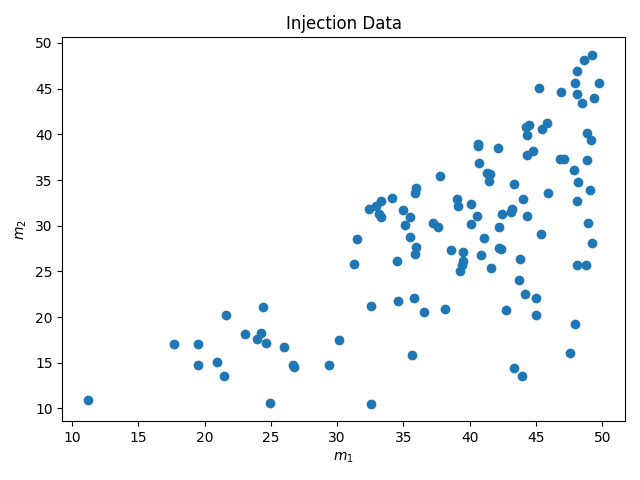

In [13]:
!gwk_scatter2d \
    --data data/realization_0/injections.dat \
    --output plots/m1m2_inj_0.png \
    --x-value-column-index 0 \
    --y-value-column-index 1 \
    --xlabel "\$m_1\$" \
    --ylabel "\$m_2\$" \
    --title "Injection Data"

display(Image(filename="plots/m1m2_inj_0.png"))

[Loading lalsimutils.py : MonteCarloMarginalization version]
  scipy :  1.14.0
  numpy :  1.26.4


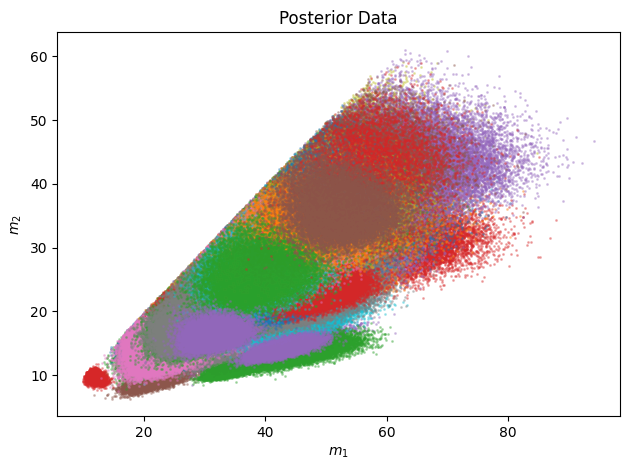

In [14]:
!gwk_batch_scatter2d \
    --data "data/realization_0/posteriors/event_*.dat" \
    --output plots/m1m2_batch_0.png \
    --x-value-column-index 0 \
    --y-value-column-index 1 \
    --xlabel "\$m_1\$" \
    --ylabel "\$m_2\$" \
    --title "Posterior Data"

display(Image(filename="plots/m1m2_batch_0.png"))

[Loading lalsimutils.py : MonteCarloMarginalization version]
  scipy :  1.14.0
  numpy :  1.26.4


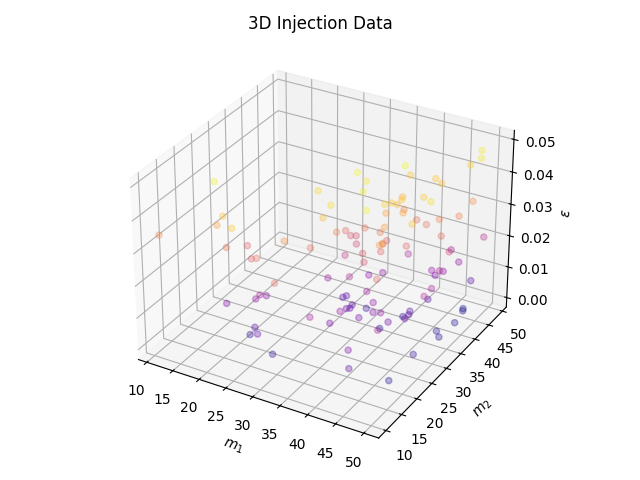

In [15]:
!gwk_scatter3d \
    --data data/realization_0/injections.dat \
    --output plots/m1m2ecc_inj_0.png \
    --x-value-column-index 0 \
    --y-value-column-index 1 \
    --z-value-column-index 2 \
    --xlabel "\$m_1\$" \
    --ylabel "\$m_2\$" \
    --zlabel "\$\epsilon\$" \
    --title "3D Injection Data" 

display(Image(filename="plots/m1m2ecc_inj_0.png"))

[Loading lalsimutils.py : MonteCarloMarginalization version]
  scipy :  1.14.0
  numpy :  1.26.4


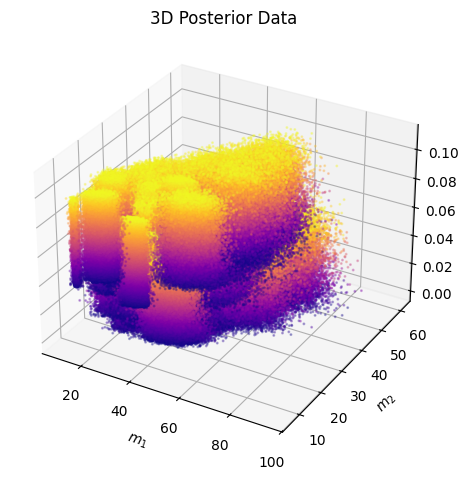

In [16]:
!gwk_batch_scatter3d \
    --data "data/realization_0/posteriors/event_*.dat" \
    --output plots/m1m2ecc_batch_0.png \
    --x-value-column-index 0 \
    --y-value-column-index 1 \
    --z-value-column-index 2 \
    --xlabel "\$m_1\$" \
    --ylabel "\$m_2\$" \
    --zlabel "\$\epsilon\$" \
    --title "3D Posterior Data"

display(Image(filename="plots/m1m2ecc_batch_0.png"))